In [1]:
import os
import keras

from keras.preprocessing.image import ImageDataGenerator

keras.__version__

'2.3.1'

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# Limits GPU-RAM usage
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# import and "clean" data

In [4]:
priming_epochs = 100
training_epochs = 50
batch_size = 5
target_width = 150
target_height = 150
target_size = (target_width, target_height)
target_shape = (target_width, target_height, 3) # 3 for color
base_dir = 'paintingsPriming'

In [5]:
def get_generator(base_dir, folderName):
    directory = os.path.join(base_dir, folderName)
    return ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory, 
        target_size= target_size, 
        batch_size= batch_size,
        shuffle=True,
        class_mode='sparse'
    )

In [6]:
priming_gen = get_generator(base_dir, 'priming')
train_gen = get_generator(base_dir, 'train')
test_gen = get_generator(base_dir, 'test')
validation_gen = get_generator(base_dir, 'validation')

Found 15 images belonging to 3 classes.
Found 195 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [7]:
numOfClasses = train_gen.num_classes

numOfPrimingSamples = priming_gen.n
numOfTrainSamples = train_gen.n
numOfTestSamples = test_gen.n
numOfValSamples = validation_gen.n

In [8]:
# Define Conv model

In [9]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape= target_shape) # honestly, I'm not sure whether height or width comes first

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
block3_pool_width = 18
block3_pool_height = 18
block3_pool_area = block3_pool_width * block3_pool_height
block3_pool_no_of_filters = 256

## Following not used, but included for completeness and your own possible experiments
block5_pool_width = 4
block5_pool_height = 4
block5_pool_area = block5_pool_width * block5_pool_height
block5_pool_no_of_filters = 512

In [12]:
from keras import Model

intermediate_layer_model = Model(inputs=conv_base.input, 
                                 outputs=conv_base.get_layer('block3_pool').output)
no_of_filters_left = 100

In [13]:
from keras.utils.np_utils import to_categorical

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, block3_pool_width, block3_pool_height, block3_pool_no_of_filters))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = intermediate_layer_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

    ### Now throwing away most of the features (= results of features)
    features = features[:,:,:,0:no_of_filters_left]
    ### convert labels 0, 1, and 2 to [1,0,0], [0,1,0] and [0,0,1] 
    labels = to_categorical(labels)
    return features, labels

In [14]:
import numpy as np

priming_features, priming_labels = extract_features(priming_gen, numOfPrimingSamples)
train_features, train_labels = extract_features(train_gen, numOfTrainSamples)
validation_features, validation_labels = extract_features(validation_gen, numOfValSamples)
test_features, test_labels = extract_features(test_gen, numOfTestSamples)

In [15]:
priming_features = np.reshape(priming_features, (numOfPrimingSamples, block3_pool_area * no_of_filters_left))
train_features = np.reshape(train_features, (numOfTrainSamples, block3_pool_area * no_of_filters_left))
validation_features = np.reshape(validation_features, (numOfValSamples, block3_pool_area * no_of_filters_left))
test_features = np.reshape(test_features, (numOfTestSamples, block3_pool_area * no_of_filters_left))

In [16]:
# Define Dense model

In [17]:
from keras import models
from keras.layers import InputLayer, Flatten, Dense, Dropout

def get_model(shape, nClasses):
    return keras.Sequential([
        InputLayer(input_shape=shape),
        #Flatten(),    ### Need to flatten if dense NN else if ConvNet no need to flatten.
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(nClasses, activation='sigmoid'),
    ],)

In [18]:
input_shape = (block3_pool_area * no_of_filters_left, )
model = get_model(input_shape, numOfClasses)

In [19]:
# train model

In [20]:
from keras import optimizers

model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), metrics=["acc"])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1036832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 1,037,123
Trainable params: 1,037,123
Non-trainable params: 0
_________________________________________________________________


In [22]:
historyP = model.fit(
    priming_features, 
    priming_labels,
    epochs=priming_epochs,
    batch_size=batch_size#,
    #validation_data=(validation_features, validation_labels)
)

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 4.6931 - acc: 0.4444
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 3.2675 - acc: 0.5778
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 1.5155 - acc: 0.5778
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 2.7124 - acc: 0.5778
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 1.9924 - acc: 0.5556
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 1.1105 - acc: 0.6444
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 1.6171 - acc: 0.6444
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.9776 - acc: 0.6222
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 1.4182 - acc: 0.5111
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.9811 - acc: 0.6222
Epoch 11/100
15/15 [==============================] - 0s 2m

In [23]:
history = model.fit(
    train_features, 
    train_labels,
    epochs=training_epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels)
)

Train on 195 samples, validate on 60 samples
Epoch 1/50
195/195 [==============================] - 0s 2ms/step - loss: 0.9958 - acc: 0.5316 - val_loss: 0.6423 - val_acc: 0.5833
Epoch 2/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6820 - acc: 0.6376 - val_loss: 0.6304 - val_acc: 0.6111
Epoch 3/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6554 - acc: 0.6769 - val_loss: 0.6193 - val_acc: 0.6444
Epoch 4/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6388 - acc: 0.6462 - val_loss: 0.6186 - val_acc: 0.5944
Epoch 5/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6204 - acc: 0.6735 - val_loss: 0.6187 - val_acc: 0.6056
Epoch 6/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6329 - acc: 0.6752 - val_loss: 0.5961 - val_acc: 0.6333
Epoch 7/50
195/195 [==============================] - 0s 2ms/step - loss: 0.6104 - acc: 0.6667 - val_loss: 0.6014 - val_acc: 0.6556
Epoch 8/50
195/195 [===========

In [24]:
#model.save('baseline.h5')

In [25]:
# validation

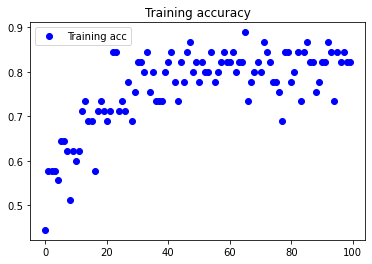

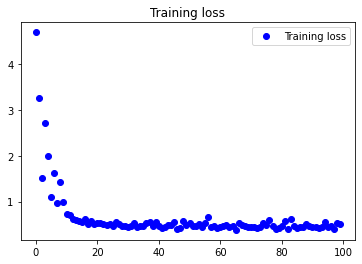

In [26]:
import matplotlib.pyplot as plt

acc = historyP.history['acc']
loss = historyP.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

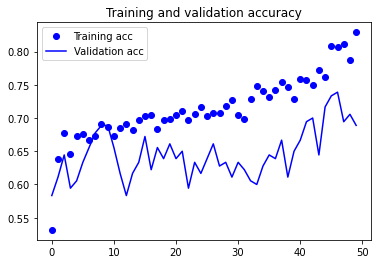

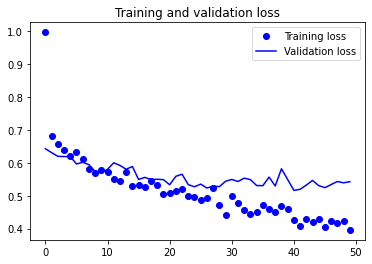

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()